In [2]:
from __future__ import print_function
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import statsmodels.api as sm



In [3]:
train_features = pd.read_csv('../Data/dengue_features_train.csv', index_col=[0, 1, 2])
train_labels = pd.read_csv('../Data/dengue_labels_train.csv', index_col=[0, 1, 2])

# Separate data by city
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

In [4]:
# remove week_start_date string
sj_train_features.drop('week_start_date', axis=1, inplace=True)
iq_train_features.drop('week_start_date', axis=1, inplace=True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [5]:
# missing data
sj_train_features.fillna(method='ffill', inplace=True)
iq_train_features.fillna(method='ffill', inplace=True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [6]:
print('San Juan')
print('mean: ', sj_train_labels.mean()[0])
print('var :', sj_train_labels.var()[0])

print('\nIquitos')
print('mean: ', iq_train_labels.mean()[0])
print('var :', iq_train_labels.var()[0])

San Juan
mean:  34.18055555555556
var : 2640.0454396910277

Iquitos
mean:  7.565384615384615
var : 115.89552393656439


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdf4f6e57c0>]],
      dtype=object)

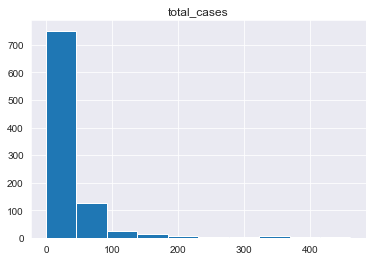

In [7]:
sj_train_labels.hist()


# Negative binomial regression

In [8]:

sj_train_features['total_cases'] = sj_train_labels.total_cases
iq_train_features['total_cases'] = iq_train_labels.total_cases
sj_correlations = sj_train_features.corr()
iq_correlations = iq_train_features.corr()

<ipython-input-8-69d79c2b7290>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sj_train_features['total_cases'] = sj_train_labels.total_cases
<ipython-input-8-69d79c2b7290>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iq_train_features['total_cases'] = iq_train_labels.total_cases


Text(0.5, 1, 'San Juan Variable Correlations')

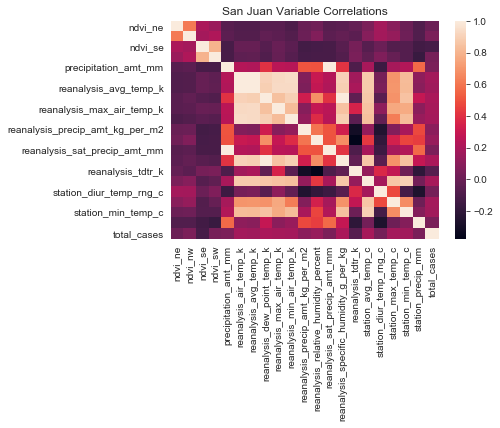

In [9]:
# plot san juan
sj_corr_heat = sns.heatmap(sj_correlations)
plt.title('San Juan Variable Correlations')

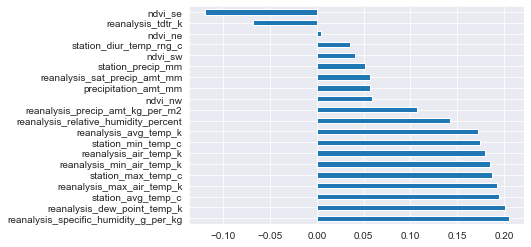

In [10]:
# San Juan
(sj_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh())

Text(0.5, 1, 'Iquitos Variable Correlations')

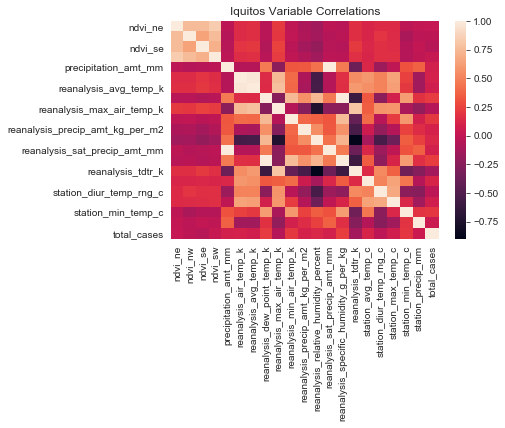

In [13]:
# plot iquitos
iq_corr_heat = sns.heatmap(iq_correlations)
plt.title('Iquitos Variable Correlations')

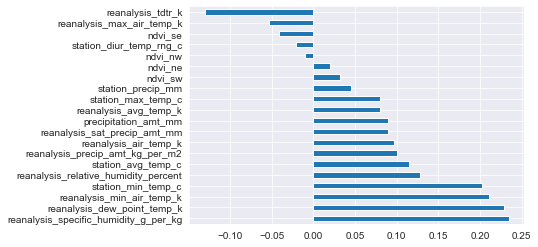

In [12]:
# Iquitos
(iq_correlations
 .total_cases
 .drop('total_cases')  # don't compare with myself
 .sort_values(ascending=False)
 .plot
 .barh())

In [14]:
def preprocess_data(data_path, labels_path=None):
    # load data and set index to city, year, weekofyear
    df = pd.read_csv(data_path, index_col=[0, 1, 2])

    # select features we want
    features = ['reanalysis_specific_humidity_g_per_kg',
                 'reanalysis_dew_point_temp_k',
                 'station_avg_temp_c',
                 'station_min_temp_c']
    df = df[features]

    # fill missing values
    df.fillna(method='ffill', inplace=True)

    # add labels to dataframe
    if labels_path:
        labels = pd.read_csv(labels_path, index_col=[0, 1, 2])
        df = df.join(labels)

    # separate san juan and iquitos
    sj = df.loc['sj']
    iq = df.loc['iq']

    return sj, iq

In [16]:
sj_train, iq_train = preprocess_data('../Data/dengue_features_train.csv',
                                    labels_path="../Data/dengue_labels_train.csv")

In [17]:
sj_train_subtrain = sj_train.head(800)
sj_train_subtest = sj_train.tail(sj_train.shape[0] - 800)

iq_train_subtrain = iq_train.head(400)
iq_train_subtest = iq_train.tail(iq_train.shape[0] - 400)

In [19]:
from statsmodels.tools import eval_measures
import statsmodels.formula.api as smf

def get_best_model(train, test):
    # Step 1: specify the form of the model
    model_formula = "total_cases ~ 1 + " \
                    "reanalysis_specific_humidity_g_per_kg + " \
                    "reanalysis_dew_point_temp_k + " \
                    "station_min_temp_c + " \
                    "station_avg_temp_c"

    grid = 10 ** np.arange(-8, -3, dtype=np.float64)

    best_alpha = []
    best_score = 1000

    # Step 2: Find the best hyper parameter, alpha
    for alpha in grid:
        model = smf.glm(formula=model_formula,
                        data=train,
                        family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)

        if score < best_score:
            best_alpha = alpha
            best_score = score

    print('best alpha = ', best_alpha)
    print('best score = ', best_score)

    # Step 3: refit on entire dataset
    full_dataset = pd.concat([train, test])
    model = smf.glm(formula=model_formula,
                    data=full_dataset,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    return fitted_model

sj_best_model = get_best_model(sj_train_subtrain, sj_train_subtest)
iq_best_model = get_best_model(iq_train_subtrain, iq_train_subtest)

best alpha =  1e-08
best score =  22.080882352941178
best alpha =  1e-08
best score =  6.466666666666667


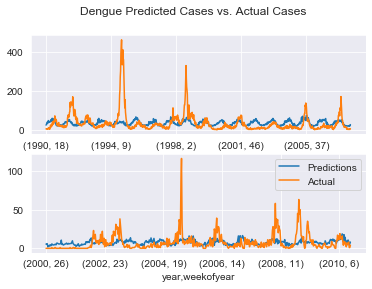

In [20]:
figs, axes = plt.subplots(nrows=2, ncols=1)

# plot sj
sj_train['fitted'] = sj_best_model.fittedvalues
sj_train.fitted.plot(ax=axes[0], label="Predictions")
sj_train.total_cases.plot(ax=axes[0], label="Actual")

# plot iq
iq_train['fitted'] = iq_best_model.fittedvalues
iq_train.fitted.plot(ax=axes[1], label="Predictions")
iq_train.total_cases.plot(ax=axes[1], label="Actual")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()